# Generative Adversarial Network (GAN)
In this exercise, we will generate pokemon using a GAN. Since GANs are very computational intensive, we will use Google Colab for this exercise, since we can run the notebook with a GPU, which speeds up the training by a lot.

To connect a GPU to your current Colab notebook, you will need to go to "Runtime" > "Change runtime type" and select "GPU" in "Hardware accelerator". This will ensure that the notebook will have access to a GPU.

In [3]:
# import packages
import os
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import zipfile
import imageio
from PIL import Image
from tqdm import tqdm
from IPython.display import clear_output

from keras.layers import *
from keras.models import *
from keras.datasets import mnist
from keras.optimizers import RMSprop
import keras.backend as K

## Upload and extract the dataset
We first need to upload the dataset to Google Colab, which can be done by opening the "files" pane on the left and click on the upload button. Then you can upload the given dataset in ZIP format. We will then extract the dataset in Colab. Uploading the dataset can take a while (5-10min).

In [9]:
# extract the pokemon data
zip_ref = zipfile.ZipFile("pokemon-dataset.zip", "r")
zip_ref.extractall("pokemon-dataset/")
zip_ref.close()

## Define Hyperparameters
As usual, we will first define our hyperparameters.

In [10]:
# hyperparameters
batch_size = 64
epochs = 30000

image_size = 64, 64, 3

Next, we will load the dataset from the extracted ZIP file. For preprocessing, we will resize the images to 64x64, to make the training a bit faster, and we will further normalize the inputs.

In [11]:
# import data
pokemon_path = "pokemon-dataset/pokemon_jpg/pokemon_jpg"
pokemon_files = np.array(sorted(os.listdir(pokemon_path)))
x_train = [imageio.imread(os.path.join(pokemon_path, x)) for x in pokemon_files]
x_train = np.asarray(x_train)

# resize the data
x_train = [Image.fromarray(np.uint8(img)).resize((64, 64)) for img in x_train]
x_train = [np.asarray(img, dtype=np.float32) for img in x_train]
x_train = np.asarray(x_train, dtype=np.float32)

# normalize data
x_train = x_train.astype("float32") / 255.0

# check number of images
print(str(x_train.shape[0]) + " images.")

819 images.


Now we can look at some random images from the dataset.

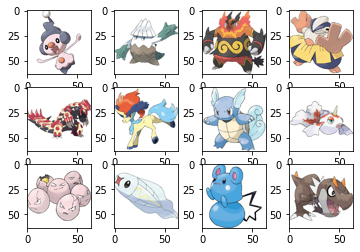

In [12]:
# plot some images of the dataset to look at our training data
image_indices = np.random.randint(0, x_train.shape[0] - 1, [12])
real_images = x_train[image_indices]

for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(real_images[i])

plt.show()

## Utility functions
Here are some definitions of utility functions, which will be used for training the network.

This function defines the **adaptive instance normalization**. A normalization technique, used in StyleGAN and StyleGAN2, which aligns the mean and the variance of the content features with those of the style features. In other words, this technique applies the style features to the content feature.

$$ AdaIN(x,y) = \sigma(y)\Big(\frac{x-\mu(x)}{\sigma(x)} \Big) + \mu(y)$$

In [13]:
def AdaIN(x):
  # normalize x[0] (image representation)
  mean = K.mean(x[0], axis = [1, 2], keepdims = True)
  std = K.std(x[0], axis = [1, 2], keepdims = True) + 1e-7
  y = (x[0] - mean) / std
  
  # reshape scale and bias parameters
  pool_shape = [-1, 1, 1, y.shape[-1]]
  scale = K.reshape(x[1], pool_shape)
  bias = K.reshape(x[2], pool_shape)
  
  # multiply by x[1] (GAMMA) and add x[2] (BETA)
  return y * scale + bias

Next, we will define the `g_block` and the `d_block`, which is a generator/discriminator block. Defining these layers as functions will make the code for the creation of the model much cleaner. 

The `g_block` follows a StyleGAN like architecture, which always consists of Upsampling, Convolution, AdaIN and an Activation.

In [14]:
def g_block(input_tensor, latent_vector, filters):
  gamma = Dense(filters, bias_initializer = "ones")(latent_vector)
  beta = Dense(filters)(latent_vector)
  
  out = UpSampling2D()(input_tensor)
  out = Conv2D(filters, 3, padding = "same")(out)
  out = Lambda(AdaIN)([out, gamma, beta])
  out = Activation("relu")(out)
  
  return out

In [15]:
def d_block(input_tensor, filters):
  out = Conv2D(filters, 3, padding = "same")(input_tensor)
  out = LeakyReLU(0.2)(out)
  out = AveragePooling2D()(out)
  return out

## Generator
First, we will define our generator, which will be responsible for generating a new image from a random one. The input to the generator (the random image) will first be mapped to the latent space using three fully connected layers. Then this latent vector will be used as input to the four generator blocks, followed by the last convolution layer, which will generate a 64x64x3 output image.

In [16]:
# latent input
latent_input = Input([64])

# map latent input
latent = Dense(64, activation = "relu")(latent_input)
latent = Dense(64, activation = "relu")(latent)
latent = Dense(64, activation = "relu")(latent)

# reshape to 4x4x64
x = Dense(4*4*64, activation = "relu")(latent_input)
x = Reshape([4, 4, 64])(x)

# size: 4x4x64
x = g_block(x, latent, 64)
# size: 8x8x64
x = g_block(x, latent, 32)
# size: 16x16x32
x = g_block(x, latent, 16)
# size: 32x32x16
x = g_block(x, latent, 8)

# size: 64x64x8, make RGB with values between 0 and 1
image_output = Conv2D(3, 1, padding = "same", activation = "sigmoid")(x)

# make Model
generator = Model(inputs = latent_input, outputs = image_output)
# model Summary
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1024)         66560       input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           4160        input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 4, 4, 64)     0           dense_3[0][0]                    
______________________________________________________________________________________________

## Discriminator
Next, we will define the discriminator, which will be responsible for distinguishing if the image is generated or real. The discriminator consists of four `d_block`, followed by a convolution. The output will then be flattened and passed to a final fully connected layer with just one neuron. This layer is responsible for outputting to which class the input belongs.

In [17]:
# image input
image_input = Input([64, 64, 3])

# size: 64x64x3
x = d_block(image_input, 8)
# size: 32x32x8
x = d_block(x, 16)
# size: 16x16x16
x = d_block(x, 32)
# size: 8x8x32
x = d_block(x, 64)

# size: 4x4x64
x = Conv2D(128, 3, padding = "same")(x)
x = LeakyReLU(0.2)(x)
x = Flatten()(x)

# 1-dimensional Neural Network
class_output = Dense(1)(x)

# make Model
discriminator = Model(inputs = image_input, outputs = class_output)
# model summary
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 8)         224       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 8)         0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 16, 16)        0   

## Build the Discriminator and the Generator
Next, we will build both the discriminator and the generator. Since both need to built together, because their training is dependent on each other, we need to make sure that when training the discriminator, we don't also train the generator and vice versa.

The discriminator will be trained by classifying the validity of the real image and then the validity of the fake image. The goal is that the discriminator can always distinguish between real and fake.

In [19]:
# build network to train the discriminator.
# discriminator will train, but Generator won't train.
for layer in discriminator.layers:
  layer.trainable = True
    
for layer in generator.layers:
  layer.trainable = False 
    
# get real image
real_image = Input([64, 64, 3])
# discriminator classifies
validity_real = discriminator(real_image)

# get latent input
latent_input = Input([64])
# generate an image
fake_image = generator(latent_input)
# discriminator classifies
validity_fake = discriminator(fake_image)

# create and compile the model
DiscriminatorModel = Model(inputs = [real_image, latent_input], 
                           outputs = [validity_real, validity_fake, validity_real])
DiscriminatorModel.compile(optimizer = RMSprop(lr = 0.0002),
                           loss = ["mean_squared_error", "mean_squared_error"])

Next, we will build the generator, which generates an image from random noise. This generated image will then be evaluated using the discriminator, with the goal that the generator can generate images, which the discriminator can not distinguish.

In [20]:
# build network to train the generator.
# discriminator won't train, but Generator will train.
for layer in discriminator.layers:
  layer.trainable = False
    
for layer in generator.layers:
  layer.trainable = True

# get latent input
latent_input = Input([64])
# generate an image
fake_image = generator(latent_input)
# discriminator classifies
validity = discriminator(fake_image)

# create and compile the model
GeneratorModel = Model(inputs = latent_input, outputs = validity)
GeneratorModel.compile(optimizer = RMSprop(lr = 0.0002), loss = "mean_squared_error")

## Training the model
After we have built the generator and discriminator, we can finally train our GAN. The training happens in two steps. First, we train the discriminator and then as a second step train the generator. The entire training will take around ~35min.

In [21]:
# statistics of the GAN training 
d_loss = [] # discriminator loss
g_loss = [] # generator loss
predictions = [] # predictions at each epoch

# train the models in a loop
for i in tqdm(range(epochs)):
  clear_output(wait=True)

  # get labels
  real_labels = np.ones([batch_size, 1])
  fake_labels = np.zeros([batch_size, 1])
  dummy_labels = np.ones([batch_size, 1])

  # train discriminator
  # get images and latent vectors
  image_indices = np.random.randint(0, x_train.shape[0] - 1, [batch_size])
  real_images = x_train[image_indices]
  latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 64])
  # train
  loss = DiscriminatorModel.train_on_batch([real_images, latent_vectors], 
                                           [real_labels, fake_labels, dummy_labels])
  d_loss.append(loss[1]/2 + loss[2]/2)

  # train generator
  # get latent vectors
  latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 64])
  # train using opposite labels
  loss = GeneratorModel.train_on_batch(latent_vectors, real_labels)
  g_loss.append(loss)

  if i % 100 == 0:
    # sample of generator
    latent_vectors = np.random.normal(0.0, 1.0, [16, 64])
    predictions.append(generator.predict(latent_vectors)[0])

100%|██████████| 30000/30000 [1:00:01<00:00,  8.33it/s]


To make sure the model has learned something during training, we can plot both the discriminator and generator loss. Since they both compete with each other, the optimal would be if both of the losses are 0.5. This would mean that the discriminator can not distinguish between the real and fake, the best it can do would be to guess. 

We can see that this optimal case is not the case in our simple example. The generator is much worse than the generator. One way to tackle the problem would be to try out a different architecture or to implement an additional loss, for example, gradient penalty loss, which would prevent the model from collapsing.

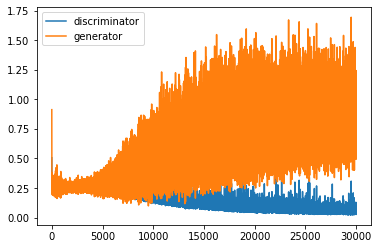

In [22]:
# plot losses
plt.plot(d_loss, label="discriminator")
plt.plot(g_loss, label="generator")
plt.legend()
plt.show()

After we have successfully trained our network, it's time to generate some images with it and look how good they are!

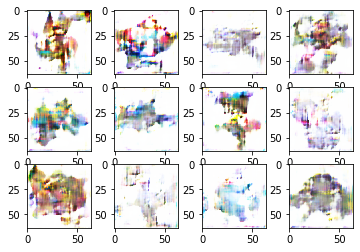

In [23]:
# show samples
latent_vectors = np.random.normal(0.0, 1.0, [12, 64])
fake_images = generator.predict(latent_vectors)

for i in range(12):
  plt.subplot(3, 4, i+1)
  plt.imshow(fake_images[i])
plt.show()

We can also visualize the generated images a bit more fancy by creating a grid of fake images.

In [26]:
latent_vectors = np.random.normal(0.0, 1.0, [2000, 64])
fake_images = generator.predict(latent_vectors)

cols = []
for i in range(200):
    cols.append(np.concatenate(fake_images[i*10:i*10+10], axis = 0))

grid = np.concatenate(cols, axis = 1)
x = Image.fromarray(np.uint8(grid*255))
x.save("prediction_grid.png")

Since we have generated an image after every 100th epoch, we can now visualize the training process as a GIF.

In [25]:
import imageio
import shutil
converted_predictions = []
for img in predictions:
  converted_predictions.append(np.uint8(img*255))
imageio.mimsave("generation.gif", converted_predictions)